# Fashion Image Generation using GANs:

In this project, we implement a Generative Adversarial Network (GAN) model to generate fashion images from a custom dataset sourced from Polyvore. The primary objective is to explore how GANs can be utilized for generating realistic images that can assist in fashion recommendations. The dataset can be accessed [here](https://github.com/AemikaChow/AiDLab-fAshIon-Data/blob/main/Datasets/cleaned-maryland.md).

## Authors
- Sajjad Saed
- Kamand Kalashi


## Project Overview

The project consists of several critical steps, including dataset preparation, model architecture design, training, and visualization. Below is a summary of the steps involved:

### 1. Dataset Preparation
- The dataset consists of fashion images organized into folders based on their respective class labels.
- Each image is read, resized to 128x128 pixels, and converted to grayscale.
- The images are normalized and split into training and test sets to ensure proper model training and evaluation.

### 2. GAN Architecture
The GAN consists of two main components: the Generator and the Discriminator.

#### Generator
- **Input Layer**: Receives a noise vector of dimension 100.
- **Layers**:
  - Dense layer reshaping the input to a feature map of size (8, 8, 512).
  - Several Conv2DTranspose layers to upsample the image to (128, 128).
  - Final layer with a tanh activation to produce an image.

#### Discriminator
- **Input Layer**: Takes in images of size (128, 128, 1).
- **Layers**:
  - Several Conv2D layers to downsample the image.
  - Flattening layer followed by a Dense layer with sigmoid activation to classify images as real or fake.

### 3. Model Compilation
- The Discriminator is compiled with:
  - **Optimizer**: Adam with a learning rate adjusted for decay.
  - **Loss Function**: Binary cross-entropy.
  
- The GAN model combines the Generator and Discriminator, with the Discriminator frozen during Generator training.

### 4. Model Training
The GAN is trained over 150 epochs with a batch size of 32. The training involves alternating between training the Discriminator and Generator while adjusting learning rates based on epoch progression. 

### 5. Results Visualization
- Plots of Generator and Discriminator loss and accuracy are generated per epoch.
- Sample images generated by the Generator are visualized to assess the quality of the generated images.

## Requirements
To run this project, ensure you have the following libraries installed:
- NumPy
- Pandas
- OpenCV
- TensorFlow
- Keras
- Matplotlib
- Seaborn

## Conclusions
This project demonstrates how GANs can effectively generate fashion images that mimic real images from the dataset. The results showcase the potential of GANs in the fashion industry, especially in areas like virtual try-ons and fashion recommendations. Future work could explore improving image quality through advanced GAN architectures or integrating the GAN with a recommendation engine to enhance user experience in fashion selection.


## Importing Required Libraries

In [1]:
# Importing required libraries
# Feature extraction and feature selection
import numpy as np
import pandas as pd

# imqage processing and visualization
import cv2
import tqdm as tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import argparse
import math
import random
import seaborn as sns

# Data training and create cnn model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, MaxPooling2D, GlobalAveragePooling2D, Flatten, Input, Multiply, Reshape, Embedding, Conv2DTranspose, BatchNormalization, LeakyReLU, Concatenate
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix,classification_report
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import itertools
import ipywidgets as widgets

# keras libraries
from keras.layers import Activation
# from keras.layers.core import Activation
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.datasets import fashion_mnist
# from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.datasets import mnist
# from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
# from keras.layers.advanced_activations import LeakyReLU
from numpy import expand_dims, zeros, asarray, ones
from numpy.random import randn, randint


In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_path = '/content/drive/MyDrive/Polyvore/'

In [5]:
# return dataset class names and count
def get_class_names(data_path):
    class_names = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    return class_names

In [6]:
# get dataset class names and count
class_names = get_class_names(dataset_path)
print("Dataset classes count:", len(class_names)," and names are:", class_names)

Dataset classes count: 8  and names are: ['bag', 'dress', 'eyewear', 'hats', 'neckwear', 'pants', 'shoes', 'watches']


In [7]:
# Constants
img_shape = (128, 128, 1)  # Adjust the image size as per our dataset
num_classes = len(class_names)
batch_size = 32
epochs = 150
z_dim = 100  # Dimension of the noise vector

In [8]:
# to resizing all data to same size (128*128)
image_size = 128
# Array to store all images with its label
all_data = []
image_count = []
count = 0

# For each index in the list of classes (class_names), by using method join with arguments dataset_path and i,
# reads all images of these classes and after resizing to 12*128, store the image with its label in all_data array
for i in class_names:
  path=os.path.join(dataset_path,i)
  class_label = class_names.index(i)
  for image in tqdm.tqdm(os.listdir(path)):
    try:
      image_array=cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
      new_image_array = cv2.resize(image_array, (image_size, image_size))
      all_data.append([new_image_array, class_label])
      # plt.imshow(new_image_array)
      # plt.show()
      # break
      if os.path.isfile(os.path.join(path,image)):
        count += 1
    except Exception as e:
      pass
  image_count.append([count, class_names[class_label]])
  count = 0
image_count

100%|██████████| 786/786 [00:14<00:00, 53.28it/s] 


[[786, 'bag'],
 [800, 'dress'],
 [780, 'eyewear'],
 [782, 'hats'],
 [791, 'neckwear'],
 [793, 'pants'],
 [789, 'shoes'],
 [786, 'watches']]

In [9]:
print(len(all_data))

6307


In [10]:
# split images and labels to X and Y arays
# images
X = []
# labels
Y = []
for i, j in all_data:
  X.append(i)
  Y.append(j)
# reshape images to 128*128 and channel 1 (black & white )
X = np.array(X).reshape(-1, image_size, image_size)
print(X.shape)
# to normalize
X = X/255
X = X.reshape(-1, 128, 128, 1)
print(X.shape)

# Converts class vector (Y) to binary class matrix --> one hot encoding
y_categorical = to_categorical(Y,num_classes = 8)

(6307, 128, 128)
(6307, 128, 128, 1)


In [11]:
# split the all_data into 80% train data and 20% test data by random state 42
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size = 0.2, random_state = 42 , shuffle = True)
# split 15% of the train data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 42, shuffle = True)

In [12]:
print('all data:', len(all_data))
print('total train data:', len(X_train) , 'and shape:', X_train.shape)
print('total validation data:', len(X_val), 'and shape:', X_val.shape)
print('total test data:', len(X_test), 'and shape:', X_test.shape)

all data: 6307
total train data: 4288 and shape: (4288, 128, 128, 1)
total validation data: 757 and shape: (757, 128, 128, 1)
total test data: 1262 and shape: (1262, 128, 128, 1)


In [13]:
X_train.shape

(4288, 128, 128, 1)

# Load and Preprocess the Data

In [14]:
# Load and preprocess the dataset
data_generator = ImageDataGenerator(rescale=1./255)
train_data = data_generator.flow_from_directory(dataset_path,
                                                target_size=(128, 128),
                                                batch_size=batch_size,
                                                color_mode='grayscale',  # Load images in grayscale
                                                class_mode=None)

Found 6307 images belonging to 8 classes.


# Define the Generator

In [15]:
def create_generator(z_dim=100):
    model = Sequential([
        # Starting layer to reshape input noise
        Dense(512 * 8 * 8, input_dim=z_dim),
        LeakyReLU(alpha=0.2),
        Reshape((8, 8, 512)),

        # Upsample to 16x16
        Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # Upsample to 32x32
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # Upsample to 64x64
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # Upsample to 128x128
        Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='tanh'),
    ])
    return model


# Define the Discriminator

In [16]:
def create_discriminator(img_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=img_shape),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        Conv2D(256, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model


In [17]:
# Adjust these values based on your observations
initial_gen_lr,gen_lr = 0.000287, 0.000287
initial_disc_lr,disc_lr = 0.000196, 0.000196
decay_factor = 0.5
epoch_to_decay = 10  # Decay every 10 epochs

# Optimizer for generator and discriminator
# optimizer = Adam(lr=initial_lr, beta_1=0.5)
optimizer_gen = Adam(lr=initial_gen_lr, beta_1=0.5)
optimizer_disc = Adam(lr=initial_disc_lr, beta_1=0.5)



# Adjust learning rate based on epoch
def adjust_learning_rate(optimizer_gen, optimizer_disc, epoch):
    gen_lr = initial_gen_lr * (decay_factor ** (epoch // epoch_to_decay))
    disc_lr = initial_disc_lr * (decay_factor ** (epoch // epoch_to_decay))

# Build the GAN

In [18]:
# Build and compile the discriminator
discriminator = create_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=disc_lr, beta_1=0.5), metrics=['accuracy'])

# Build the generator
generator = create_generator(z_dim)

# Build and compile the GAN
discriminator.trainable = False  # Freeze discriminator during generator training

gan_input = Input(shape=(z_dim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=gen_lr, beta_1=0.5))

# Training the GAN

In [19]:
# Train the GAN
def train_gan(generator, discriminator, gan, train_generator, epochs, z_dim):
    # Initialize lists to store generator and discriminator losses and accuracies
    discriminator_losses, generator_losses, discriminator_accuracies = [], [], []

    for epoch in range(epochs):
        # adjusting learning rate before starting an epoch
        adjust_learning_rate(optimizer_gen,optimizer_disc, epoch)
        for _ in range(train_generator.samples // train_generator.batch_size):
            # Sample random noise to generate fake images
            noise = np.random.normal(0, 1, (train_generator.batch_size, z_dim))
            fake_images = generator.predict(noise)

            # Get a batch of real images
            real_images = next(train_generator)[0] if train_generator.class_mode is None else next(train_generator)[0][0]

            if len(real_images.shape) == 3:  # Missing batch dimension
              real_images = np.expand_dims(real_images, axis=0)  # Add batch dimension

            actual_batch_size = real_images.shape[0]

            # Labels for real and fake images
            real_y = np.ones((actual_batch_size, 1))
            fake_y = np.zeros((actual_batch_size, 1))

            # Train the discriminator (real classified as ones and generated (fake) as zeros)
            d_loss_real, d_acc_real = discriminator.train_on_batch(real_images, real_y)
            # d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_images, fake_y)
            d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_images[:actual_batch_size], fake_y)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_acc = 0.5 * np.add(d_acc_real, d_acc_fake)

            # Train the generator (wants discriminator to mistake images as real)
            noise = np.random.normal(0, 1, (actual_batch_size, z_dim))
            g_loss = gan.train_on_batch(noise, real_y)

        # Save losses and accuracies so you can plot them later
        discriminator_losses.append(d_loss)
        generator_losses.append(g_loss)
        discriminator_accuracies.append(d_acc)

        # Optionally, print the progress
        # print('Epoch:%d, discriminator_loss=%.3f, generator_loss=%.3f, discriminator_ACC=%.3f' %(i+1, discriminator_losses[i]/epoch, generator_losses[i]/epoch, discriminator_accuracies[i]/epoch))
        print(f"Epoch: {epoch+1}/{epochs}, discriminator_loss: {d_loss}, generator_loss: {g_loss}, discriminator_ACC: {d_acc}")

    generator.save('generator.h5')
    discriminator.save('discriminator.h5')
    gan.save('gan.h5')

    return discriminator_losses, generator_losses, discriminator_accuracies

# Begin training
d_losses, g_losses, d_accuracies = train_gan(generator, discriminator, gan, train_data, epochs, z_dim)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 16ms/step
Epoch: 125/150, discriminator_loss: 0.20175727732112136, generator_loss: 18.17778968811035, discriminator_ACC: 1.0
1/1 [==============================] - 0s 16ms/step
Epoch: 126/150, discriminator_loss: 0.4226851917537715, generator_loss: 0.0007183616398833692, discriminator_ACC: 0.5
1/1 [==============================] - 0s 15ms/step
Epoch: 127/150, discriminator_loss: 0.731475698825534, generator_loss: 5.5691704750061035, discriminator_ACC: 0.5
1/1 [==============================] - 0s 22ms/step
Epoch: 128/150, discriminator_loss: 0.5027136281132698, generator_loss: 2.6471708380881864e-08, discriminator_ACC: 0.5
1/1 [==============================] - 0s 30ms/step
Epoch: 129/150, discriminator_loss: 2.844847468135413, generator_loss: 0.013701972551643848, discriminator_ACC: 0.5
1/1 [==============================] - 0s 17ms/step
Epoch: 130/150, discriminator_loss: 2.892919182777405, 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 150/150, discriminator_loss: 0.013677723839035136, generator_loss: 36.81424331665039, discriminator_ACC: 1.0


# Plotting the generator and discriminator's loss and accuracy per epoch

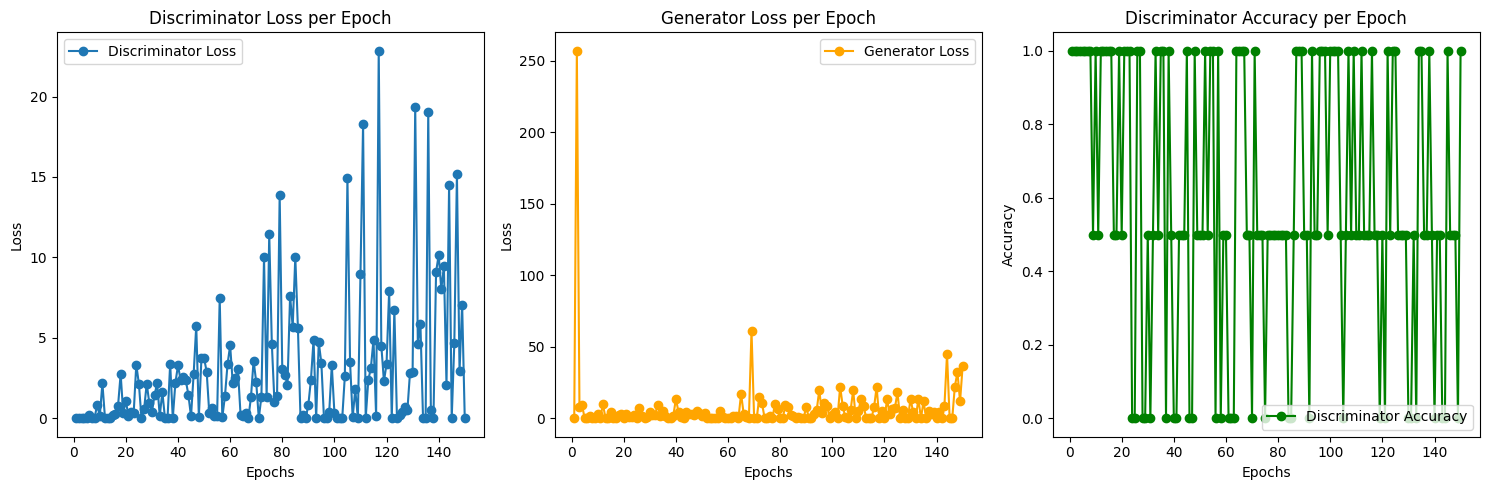

In [20]:
plt.figure(figsize=(15, 5))

# Plot discriminator's loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), d_losses, label='Discriminator Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss per Epoch')
plt.legend()

# Plot generator's loss
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), g_losses, label='Generator Loss', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss per Epoch')
plt.legend()

# Plot discriminator's accuracy
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), d_accuracies, label='Discriminator Accuracy', color='green', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Visualize Generated Images

1/1 [==============================] - 1s 604ms/step


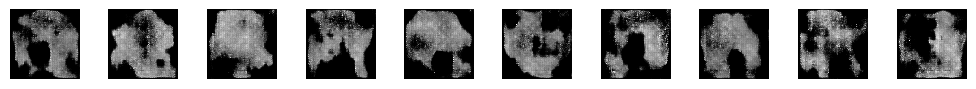

In [21]:
# Visualize Generated Images
def plot_generated_images(generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 128, 128, 1)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_generated_images(generator)